# Adjust the architecutre of pre-train model to our model 

In [1]:
import os
import json
import logging
import warnings
from datetime import datetime
from pathlib import Path
import shutil

import torch
import torch.nn as nn
from transformers import (
    ViTImageProcessor, 
    ViTForImageClassification,
    ViTConfig
)

from tqdm.auto import tqdm
import numpy as np

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('model_adjustment.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class ModelAdjustmentConfig:
    """Configuration class for model architecture adjustment"""
    
    def __init__(self):
        # Model paths
        self.base_model_path = '/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/raw_model'
        self.output_model_path = '/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model'
        self.adjusted_model_name = 'breast_cancer_vit_adjusted'
        
        # Task-specific parameters
        self.num_classes = 2  # Binary classification: cancer/no cancer
        self.task_name = 'breast_cancer_detection'
        self.class_names = ['normal', 'cancer']
        
        # Model configuration
        self.dropout_rate = 0.1
        self.label_smoothing = 0.1
        self.hidden_dropout_prob = 0.1
        self.attention_probs_dropout_prob = 0.1
        
        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        logger.info(f"Configuration initialized for {self.task_name}")
        logger.info(f"Target classes: {self.num_classes} ({', '.join(self.class_names)})")
        logger.info(f"Device: {self.device}")

class ViTModelAdjuster:
    """Class for adjusting ViT model architecture for specific tasks"""
    
    def __init__(self, config: ModelAdjustmentConfig):
        self.config = config
        self.processor = None
        self.original_model = None
        self.adjusted_model = None
        self.model_config = None
        
    def create_output_directory(self):
        """Create output directory structure"""
        output_path = Path(self.config.output_model_path)
        output_path.mkdir(parents=True, exist_ok=True)
        
        adjusted_model_path = output_path / self.config.adjusted_model_name
        adjusted_model_path.mkdir(parents=True, exist_ok=True)
        
        logger.info(f"Created output directory: {adjusted_model_path}")
        return str(adjusted_model_path)
    
    def load_original_model(self):
        """Load the original pre-trained model"""
        try:
            logger.info("Loading original ViT model and processor...")
            
            # Check if local model exists
            if os.path.exists(self.config.base_model_path):
                logger.info(f"Loading from local path: {self.config.base_model_path}")
                
                # Load processor
                self.processor = ViTImageProcessor.from_pretrained(self.config.base_model_path)
                
                # Load model configuration
                self.model_config = ViTConfig.from_pretrained(self.config.base_model_path)
                
                # Load original model
                self.original_model = ViTForImageClassification.from_pretrained(
                    self.config.base_model_path
                )
                
            else:
                logger.info("Local model not found. Loading from Hugging Face...")
                
                # Load processor
                self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
                
                # Load model configuration
                self.model_config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
                
                # Load original model
                self.original_model = ViTForImageClassification.from_pretrained(
                    'google/vit-base-patch16-224'
                )
            
            logger.info(f"Original model loaded successfully")
            logger.info(f"Original number of classes: {self.model_config.num_labels}")
            logger.info(f"Model architecture: {self.model_config.architectures}")
            
        except Exception as e:
            logger.error(f"Error loading original model: {str(e)}")
            raise
    
    def print_model_info(self, model, title="Model Information"):
        """Print detailed model information"""
        logger.info(f"\n{'='*50}")
        logger.info(f"{title}")
        logger.info(f"{'='*50}")
        
        # Model configuration
        config = model.config
        logger.info(f"Architecture: {config.architectures}")
        logger.info(f"Number of labels: {config.num_labels}")
        logger.info(f"Hidden size: {config.hidden_size}")
        logger.info(f"Number of attention heads: {config.num_attention_heads}")
        logger.info(f"Number of layers: {config.num_hidden_layers}")
        logger.info(f"Image size: {config.image_size}")
        logger.info(f"Patch size: {config.patch_size}")
        
        # Classifier layer info
        if hasattr(model, 'classifier'):
            classifier = model.classifier
            logger.info(f"Classifier input features: {classifier.in_features}")
            logger.info(f"Classifier output features: {classifier.out_features}")
        
        # Model parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        logger.info(f"Total parameters: {total_params:,}")
        logger.info(f"Trainable parameters: {trainable_params:,}")
        logger.info(f"{'='*50}\n")
    
    def adjust_model_architecture(self):
        """Adjust model architecture for the target task"""
        try:
            logger.info("Adjusting model architecture for breast cancer classification...")
            
            # Create new configuration with adjusted parameters
            new_config = ViTConfig.from_pretrained(
                self.config.base_model_path if os.path.exists(self.config.base_model_path) 
                else 'google/vit-base-patch16-224'
            )
            
            # Update configuration for the new task
            new_config.num_labels = self.config.num_classes
            new_config.id2label = {i: label for i, label in enumerate(self.config.class_names)}
            new_config.label2id = {label: i for i, label in enumerate(self.config.class_names)}
            new_config.problem_type = "single_label_classification"
            
            # Update dropout rates for better regularization
            new_config.hidden_dropout_prob = self.config.hidden_dropout_prob
            new_config.attention_probs_dropout_prob = self.config.attention_probs_dropout_prob
            
            # Add task-specific metadata
            new_config.task_specific_params = {
                "task_name": self.config.task_name,
                "num_classes": self.config.num_classes,
                "class_names": self.config.class_names,
                "adjustment_date": datetime.now().isoformat(),
                "base_model": "google/vit-base-patch16-224"
            }
            
            logger.info("Creating adjusted model with new configuration...")
            
            # Create new model with adjusted configuration
            self.adjusted_model = ViTForImageClassification(new_config)
            
            # Copy weights from original model (except classifier layer)
            self.copy_pretrained_weights()
            
            # Initialize new classifier layer
            self.initialize_classifier_layer()
            
            logger.info("Model architecture adjusted successfully!")
            
        except Exception as e:
            logger.error(f"Error adjusting model architecture: {str(e)}")
            raise
    
    def copy_pretrained_weights(self):
        """Copy weights from original model to adjusted model (except classifier)"""
        logger.info("Copying pre-trained weights...")
        
        # Get state dictionaries
        original_state_dict = self.original_model.state_dict()
        adjusted_state_dict = self.adjusted_model.state_dict()
        
        # Copy all weights except classifier
        copied_layers = []
        skipped_layers = []
        
        for name, param in original_state_dict.items():
            if name in adjusted_state_dict and not name.startswith('classifier'):
                if param.shape == adjusted_state_dict[name].shape:
                    adjusted_state_dict[name].copy_(param)
                    copied_layers.append(name)
                else:
                    skipped_layers.append(f"{name} (shape mismatch)")
            elif name.startswith('classifier'):
                skipped_layers.append(f"{name} (classifier layer)")
            else:
                skipped_layers.append(f"{name} (not found in target)")
        
        # Load the updated state dict
        self.adjusted_model.load_state_dict(adjusted_state_dict)
        
        logger.info(f"Copied weights for {len(copied_layers)} layers")
        logger.info(f"Skipped {len(skipped_layers)} layers:")
        for layer in skipped_layers[:5]:  # Show first 5 skipped layers
            logger.info(f"  - {layer}")
        if len(skipped_layers) > 5:
            logger.info(f"  ... and {len(skipped_layers) - 5} more")
    
    def initialize_classifier_layer(self):
        """Initialize the new classifier layer with proper weights"""
        logger.info("Initializing new classifier layer...")
        
        # Get the classifier layer
        classifier = self.adjusted_model.classifier
        
        # Initialize with Xavier/Glorot initialization
        nn.init.xavier_uniform_(classifier.weight)
        nn.init.constant_(classifier.bias, 0)
        
        logger.info(f"Classifier initialized - Input: {classifier.in_features}, Output: {classifier.out_features}")
    
    def validate_adjusted_model(self):
        """Validate the adjusted model"""
        logger.info("Validating adjusted model...")
        
        try:
            # Create dummy input
            dummy_input = torch.randn(1, 3, 224, 224)
            
            # Test forward pass
            self.adjusted_model.eval()
            with torch.no_grad():
                outputs = self.adjusted_model(pixel_values=dummy_input)
                logits = outputs.logits
            
            # Validate output shape
            expected_shape = (1, self.config.num_classes)
            actual_shape = logits.shape
            
            if actual_shape == expected_shape:
                logger.info(f"✓ Model validation successful! Output shape: {actual_shape}")
                
                # Test probability distribution
                probabilities = torch.softmax(logits, dim=-1)
                logger.info(f"✓ Sample output probabilities: {probabilities.squeeze().tolist()}")
                
                return True
            else:
                logger.error(f"✗ Model validation failed! Expected shape: {expected_shape}, Got: {actual_shape}")
                return False
                
        except Exception as e:
            logger.error(f"✗ Model validation failed with error: {str(e)}")
            return False
    
    def save_adjusted_model(self):
        """Save the adjusted model and processor"""
        try:
            # Create output directory
            output_dir = self.create_output_directory()
            
            logger.info(f"Saving adjusted model to: {output_dir}")
            
            # Save model
            self.adjusted_model.save_pretrained(output_dir)
            logger.info("✓ Model saved successfully")
            
            # Save processor
            self.processor.save_pretrained(output_dir)
            logger.info("✓ Processor saved successfully")
            
            # Save adjustment metadata
            metadata = {
                "adjustment_info": {
                    "original_model": "google/vit-base-patch16-224",
                    "task": self.config.task_name,
                    "num_classes": self.config.num_classes,
                    "class_names": self.config.class_names,
                    "adjustment_date": datetime.now().isoformat()
                },
                "model_config": {
                    "hidden_size": self.adjusted_model.config.hidden_size,
                    "num_attention_heads": self.adjusted_model.config.num_attention_heads,
                    "num_hidden_layers": self.adjusted_model.config.num_hidden_layers,
                    "image_size": self.adjusted_model.config.image_size,
                    "patch_size": self.adjusted_model.config.patch_size,
                    "num_labels": self.adjusted_model.config.num_labels
                },
                "usage_instructions": {
                    "loading": "Use ViTForImageClassification.from_pretrained() to load this model",
                    "processor": "Use ViTImageProcessor.from_pretrained() to load the processor",
                    "input_size": "224x224 RGB images",
                    "output": f"{self.config.num_classes} class probabilities"
                }
            }
            
            metadata_path = os.path.join(output_dir, 'adjustment_metadata.json')
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)
            
            logger.info(f"✓ Metadata saved to: {metadata_path}")
            
            # Create README file
            readme_content = self.create_readme_content(output_dir)
            readme_path = os.path.join(output_dir, 'README.md')
            with open(readme_path, 'w') as f:
                f.write(readme_content)
            
            logger.info(f"✓ README created: {readme_path}")
            
            return output_dir
            
        except Exception as e:
            logger.error(f"Error saving adjusted model: {str(e)}")
            raise
    
    def create_readme_content(self, model_path):
        """Create README content for the adjusted model"""
        readme = f"""# Breast Cancer Detection ViT Model (Adjusted)

## Model Information
- **Base Model**: google/vit-base-patch16-224
- **Task**: Binary classification for breast cancer detection
- **Classes**: {self.config.num_classes} ({', '.join(self.config.class_names)})
- **Adjustment Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Architecture
- **Input Size**: 224x224 RGB images
- **Hidden Size**: {self.adjusted_model.config.hidden_size}
- **Attention Heads**: {self.adjusted_model.config.num_attention_heads}
- **Layers**: {self.adjusted_model.config.num_hidden_layers}
- **Parameters**: {sum(p.numel() for p in self.adjusted_model.parameters()):,}

## Usage

### Loading the Model
```python
from transformers import ViTForImageClassification, ViTImageProcessor

# Load model and processor
model = ViTForImageClassification.from_pretrained('{model_path}')
processor = ViTImageProcessor.from_pretrained('{model_path}')
```

### Inference Example
```python
import torch
from PIL import Image

# Load and preprocess image
image = Image.open('path/to/mri_image.jpg')
inputs = processor(images=image, return_tensors="pt")

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get predicted class
predicted_class_id = predictions.argmax().item()
predicted_class = {self.config.class_names}[predicted_class_id]
confidence = predictions[0][predicted_class_id].item()

print(f"Prediction: {{predicted_class}} (Confidence: {{confidence:.4f}})")
```

## Fine-tuning Ready
This model is ready for fine-tuning on your breast cancer dataset. The classifier layer has been properly initialized for binary classification.

## Notes
- The model uses the original ViT-Base architecture with an adjusted classifier layer
- All pre-trained weights from ImageNet are preserved except for the final classification layer
- The classifier layer has been randomly initialized and needs fine-tuning on your dataset
"""
        return readme
    
    def run_adjustment_process(self):
        """Run the complete model adjustment process"""
        try:
            logger.info("Starting ViT model adjustment process...")
            
            # Step 1: Load original model
            with tqdm(total=5, desc="Model Adjustment Progress") as pbar:
                self.load_original_model()
                pbar.set_description("Original model loaded")
                pbar.update(1)
                
                # Print original model info
                self.print_model_info(self.original_model, "Original Model Information")
                
                # Step 2: Adjust architecture
                self.adjust_model_architecture()
                pbar.set_description("Architecture adjusted")
                pbar.update(1)
                
                # Print adjusted model info
                self.print_model_info(self.adjusted_model, "Adjusted Model Information")
                
                # Step 3: Validate adjusted model
                validation_success = self.validate_adjusted_model()
                if not validation_success:
                    raise Exception("Model validation failed!")
                pbar.set_description("Model validated")
                pbar.update(1)
                
                # Step 4: Save adjusted model
                output_path = self.save_adjusted_model()
                pbar.set_description("Model saved")
                pbar.update(1)
                
                # Step 5: Final verification
                self.verify_saved_model(output_path)
                pbar.set_description("Verification complete")
                pbar.update(1)
            
            logger.info("✅ Model adjustment completed successfully!")
            logger.info(f"Adjusted model saved to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"❌ Model adjustment failed: {str(e)}")
            raise
    
    def verify_saved_model(self, model_path):
        """Verify that the saved model can be loaded correctly"""
        try:
            logger.info("Verifying saved model...")
            
            # Load the saved model
            loaded_model = ViTForImageClassification.from_pretrained(model_path)
            loaded_processor = ViTImageProcessor.from_pretrained(model_path)
            
            # Test with dummy input
            dummy_input = torch.randn(1, 3, 224, 224)
            
            loaded_model.eval()
            with torch.no_grad():
                outputs = loaded_model(pixel_values=dummy_input)
                logits = outputs.logits
            
            if logits.shape == (1, self.config.num_classes):
                logger.info("✅ Saved model verification successful!")
                return True
            else:
                logger.error("❌ Saved model verification failed!")
                return False
                
        except Exception as e:
            logger.error(f"❌ Error verifying saved model: {str(e)}")
            return False

def main():
    """Main execution function"""
    logger.info("🚀 Starting ViT Model Adjustment for Breast Cancer Detection")
    
    try:
        # Initialize configuration
        config = ModelAdjustmentConfig()
        
        # Initialize model adjuster
        adjuster = ViTModelAdjuster(config)
        
        # Run adjustment process
        output_path = adjuster.run_adjustment_process()
        
        logger.info("🎉 Process completed successfully!")
        logger.info(f"📁 Adjusted model location: {output_path}")
        logger.info("📋 Next steps:")
        logger.info("   1. Use this adjusted model for fine-tuning on your dataset")
        logger.info("   2. The model is ready for training with your breast cancer data")
        logger.info("   3. Check the README.md file for usage instructions")
        
        return output_path
        
    except Exception as e:
        logger.error(f"💥 Process failed: {str(e)}")
        raise

# For Jupyter Notebook usage
if __name__ == "__main__":
    print("🔬 ViT Model Adjustment for Breast Cancer Detection")
    print("=" * 60)
    print("This script will adjust the ViT model architecture for binary classification.")
    print("The model will be ready for fine-tuning on your breast cancer dataset.")
    print("=" * 60)
    
    # Run the adjustment process
    try:
        output_path = main()
        print(f"\n✅ SUCCESS: Model adjusted and saved to: {output_path}")
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("Please check the logs for more details.")

2025-07-01 08:47:16,605 - INFO - 🚀 Starting ViT Model Adjustment for Breast Cancer Detection
2025-07-01 08:47:16,606 - INFO - Configuration initialized for breast_cancer_detection
2025-07-01 08:47:16,607 - INFO - Target classes: 2 (normal, cancer)
2025-07-01 08:47:16,607 - INFO - Device: cpu
2025-07-01 08:47:16,607 - INFO - Starting ViT model adjustment process...


🔬 ViT Model Adjustment for Breast Cancer Detection
This script will adjust the ViT model architecture for binary classification.
The model will be ready for fine-tuning on your breast cancer dataset.


Model Adjustment Progress:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-01 08:47:16,628 - INFO - Loading original ViT model and processor...
2025-07-01 08:47:16,637 - INFO - Loading from local path: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/raw_model
2025-07-01 08:47:16,884 - INFO - Original model loaded successfully
2025-07-01 08:47:16,884 - INFO - Original number of classes: 1000
2025-07-01 08:47:16,885 - INFO - Model architecture: ['ViTForImageClassification']
2025-07-01 08:47:16,886 - INFO - 
2025-07-01 08:47:16,886 - INFO - Original Model Information
2025-07-01 08:47:16,887 - INFO - ==================================================
2025-07-01 08:47:16,888 - INFO - Architecture: ['ViTForImageClassification']
2025-07-01 08:47:16,888 - INFO - Number of labels: 1000
2025-07-01 08:47:16,889 - INFO - Hidden size: 768
2025-07-01 08:47:16,889 - INFO - Number of attention heads: 12
2025-07-01 08:47:16,890 - INFO - Number of layers: 12
2025-07-01 08:47:16,890 - INFO - Image size: 224
2025-07-01 08:47:16,891 - INFO - Patch size: 16
2025-07-


✅ SUCCESS: Model adjusted and saved to: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_adjusted


## Try to unfreeze the model 

In [2]:
import os
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTConfig
from tqdm import tqdm
import time
import json
from datetime import datetime

class ViTFreezeManager:
    def __init__(self, model_path, save_path):
        """
        Initialize the ViT Freeze Manager
        
        Args:
            model_path: Path to the adjusted model
            save_path: Path to save the processed model
        """
        self.model_path = model_path
        self.save_path = save_path
        self.model = None
        
        # Create save directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)
        
    def load_model(self):
        """Load the adjusted ViT model"""
        print("Loading adjusted ViT model...")
        try:
            self.model = ViTForImageClassification.from_pretrained(self.model_path)
            print(f"✓ Model loaded successfully from {self.model_path}")
            return True
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            return False
    
    def get_model_summary(self):
        """Get model summary and layer information"""
        if self.model is None:
            print("Model not loaded!")
            return
        
        print("\n" + "="*60)
        print("MODEL SUMMARY")
        print("="*60)
        
        # Basic model info
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f"Model: {self.model.__class__.__name__}")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Frozen Parameters: {frozen_params:,}")
        print(f"Trainable Percentage: {(trainable_params/total_params)*100:.2f}%")
        
        # Layer-wise breakdown
        print(f"\nLayer-wise Parameter Status:")
        print("-" * 50)
        
        for name, param in self.model.named_parameters():
            status = "Trainable" if param.requires_grad else "Frozen"
            print(f"{name:<40} | {status:<10} | {param.numel():>8,} params")
    
    def freeze_backbone_only(self):
        """
        Freeze only the ViT backbone (feature extractor), keep classifier trainable
        Recommended for transfer learning with limited data
        """
        print("\nApplying FREEZE BACKBONE strategy...")
        print("- Freezing: ViT backbone (embeddings + encoder)")
        print("- Keeping trainable: Classifier head")
        
        frozen_count = 0
        trainable_count = 0
        
        with tqdm(total=len(list(self.model.named_parameters())), 
                  desc="Processing layers", 
                  bar_format='{l_bar}{bar:30}{r_bar}') as pbar:
            
            for name, param in self.model.named_parameters():
                # Freeze backbone components (embeddings and encoder)
                if any(component in name for component in ['embeddings', 'encoder']):
                    param.requires_grad = False
                    frozen_count += 1
                    status = "FROZEN"
                else:
                    # Keep classifier and layer norm trainable
                    param.requires_grad = True
                    trainable_count += 1
                    status = "TRAINABLE"
                
                pbar.set_postfix({
                    'Layer': name.split('.')[0], 
                    'Status': status,
                    'Frozen': frozen_count,
                    'Trainable': trainable_count
                })
                pbar.update(1)
                time.sleep(0.01)  # Small delay for visual effect
        
        print(f"\n✓ Freeze Backbone completed!")
        print(f"  - Frozen layers: {frozen_count}")
        print(f"  - Trainable layers: {trainable_count}")
        
        return "freeze_backbone"
    
    def unfreeze_last_layers(self, num_layers=2):
        """
        Unfreeze the last N encoder layers + classifier
        Recommended for fine-tuning with sufficient data
        """
        print(f"\nApplying UNFREEZE LAST {num_layers} LAYERS strategy...")
        print(f"- Freezing: Early ViT layers")
        print(f"- Unfreezing: Last {num_layers} encoder layers + classifier")
        
        # First freeze everything
        for param in self.model.parameters():
            param.requires_grad = False
        
        frozen_count = 0
        trainable_count = 0
        
        with tqdm(total=len(list(self.model.named_parameters())), 
                  desc="Processing layers", 
                  bar_format='{l_bar}{bar:30}{r_bar}') as pbar:
            
            for name, param in self.model.named_parameters():
                should_unfreeze = False
                
                # Always unfreeze classifier
                if 'classifier' in name:
                    should_unfreeze = True
                
                # Unfreeze last N encoder layers
                if 'encoder.layer' in name:
                    layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                    total_layers = self.model.config.num_hidden_layers
                    if layer_num >= (total_layers - num_layers):
                        should_unfreeze = True
                
                if should_unfreeze:
                    param.requires_grad = True
                    trainable_count += 1
                    status = "TRAINABLE"
                else:
                    param.requires_grad = False
                    frozen_count += 1
                    status = "FROZEN"
                
                pbar.set_postfix({
                    'Layer': name.split('.')[0], 
                    'Status': status,
                    'Frozen': frozen_count,
                    'Trainable': trainable_count
                })
                pbar.update(1)
                time.sleep(0.01)
        
        print(f"\n✓ Unfreeze Last Layers completed!")
        print(f"  - Frozen layers: {frozen_count}")
        print(f"  - Trainable layers: {trainable_count}")
        
        return f"unfreeze_last_{num_layers}"
    
    def full_unfreeze(self):
        """
        Unfreeze all layers for complete fine-tuning
        Use with caution - requires large dataset
        """
        print("\nApplying FULL UNFREEZE strategy...")
        print("- Unfreezing: All model parameters")
        
        trainable_count = 0
        
        with tqdm(total=len(list(self.model.named_parameters())), 
                  desc="Unfreezing all layers", 
                  bar_format='{l_bar}{bar:30}{r_bar}') as pbar:
            
            for name, param in self.model.named_parameters():
                param.requires_grad = True
                trainable_count += 1
                
                pbar.set_postfix({
                    'Layer': name.split('.')[0], 
                    'Status': 'TRAINABLE',
                    'Count': trainable_count
                })
                pbar.update(1)
                time.sleep(0.01)
        
        print(f"\n✓ Full Unfreeze completed!")
        print(f"  - All {trainable_count} layers are trainable")
        
        return "full_unfreeze"
    
    def save_model(self, strategy_name):
        """Save the processed model with strategy information"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_dir = os.path.join(self.save_path, f"breast_cancer_vit_{strategy_name}_{timestamp}")
        
        print(f"\nSaving model to: {model_dir}")
        
        # Create directory
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model with progress bar
        with tqdm(total=3, desc="Saving model", bar_format='{l_bar}{bar:30}{r_bar}') as pbar:
            
            # Save model
            pbar.set_postfix_str("Saving model weights...")
            self.model.save_pretrained(model_dir)
            pbar.update(1)
            
            # Save strategy info
            pbar.set_postfix_str("Saving strategy info...")
            strategy_info = {
                "strategy": strategy_name,
                "timestamp": timestamp,
                "total_parameters": sum(p.numel() for p in self.model.parameters()),
                "trainable_parameters": sum(p.numel() for p in self.model.parameters() if p.requires_grad),
                "model_type": "ViT-Base-Patch16-224",
                "task": "breast_cancer_detection",
                "dataset_size": "64500_images"
            }
            
            with open(os.path.join(model_dir, "strategy_info.json"), 'w') as f:
                json.dump(strategy_info, f, indent=2)
            pbar.update(1)
            
            # Create README
            pbar.set_postfix_str("Creating documentation...")
            readme_content = f"""# Breast Cancer Detection Model - {strategy_name.title()}

## Model Information
- **Base Model**: google/vit-base-patch16-224
- **Task**: Breast Cancer Detection
- **Strategy**: {strategy_name.replace('_', ' ').title()}
- **Created**: {timestamp}
- **Dataset Size**: 64,500 images
- **Image Size**: 224x224

## Strategy Details
"""
            if "freeze_backbone" in strategy_name:
                readme_content += """
- **Frozen**: ViT backbone (embeddings + encoder layers)
- **Trainable**: Classification head only
- **Recommended for**: Limited data, quick training
"""
            elif "unfreeze_last" in strategy_name:
                readme_content += f"""
- **Frozen**: Early ViT layers
- **Trainable**: Last {strategy_name.split('_')[-1]} encoder layers + classifier
- **Recommended for**: Moderate data, balanced approach
"""
            elif "full_unfreeze" in strategy_name:
                readme_content += """
- **Frozen**: None
- **Trainable**: All layers
- **Recommended for**: Large dataset, full fine-tuning
"""
            
            readme_content += f"""
## Parameters
- **Total Parameters**: {strategy_info['total_parameters']:,}
- **Trainable Parameters**: {strategy_info['trainable_parameters']:,}
- **Frozen Parameters**: {strategy_info['total_parameters'] - strategy_info['trainable_parameters']:,}

## Usage
```python
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained('{model_dir}')
```
"""
            
            with open(os.path.join(model_dir, "README.md"), 'w') as f:
                f.write(readme_content)
            pbar.update(1)
        
        print(f"✓ Model saved successfully!")
        print(f"  - Model directory: {model_dir}")
        print(f"  - Strategy: {strategy_name}")
        
        return model_dir

def recommend_strategy(dataset_size=64500):
    """Recommend the best strategy based on dataset size and task"""
    print("\n" + "="*60)
    print("STRATEGY RECOMMENDATION")
    print("="*60)
    
    if dataset_size < 10000:
        recommendation = "freeze_backbone"
        reason = "Small dataset - freeze backbone to prevent overfitting"
    elif dataset_size < 50000:
        recommendation = "unfreeze_last_2"
        reason = "Medium dataset - unfreeze last layers for better adaptation"
    else:
        recommendation = "unfreeze_last_3"
        reason = "Large dataset - unfreeze more layers for better performance"
    
    print(f"Dataset Size: {dataset_size:,} images")
    print(f"Task: Breast Cancer Detection (Medical)")
    print(f"Recommended Strategy: {recommendation.replace('_', ' ').title()}")
    print(f"Reason: {reason}")
    print("\nNote: For medical imaging, conservative approaches often work better!")
    
    return recommendation

def main():
    """Main execution function"""
    print("🏥 ViT Breast Cancer Detection - Freeze/Unfreeze Manager")
    print("="*60)
    
    # Paths
    model_path = "/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_adjusted"
    save_path = "/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model"
    
    # Initialize manager
    manager = ViTFreezeManager(model_path, save_path)
    
    # Load model
    if not manager.load_model():
        return
    
    # Show initial model summary
    manager.get_model_summary()
    
    # Get recommendation
    recommended_strategy = recommend_strategy(64500)
    
    # Apply strategy based on recommendation
    print(f"\n⚡ Applying recommended strategy: {recommended_strategy}")
    
    if recommended_strategy == "freeze_backbone":
        strategy_applied = manager.freeze_backbone_only()
    elif "unfreeze_last" in recommended_strategy:
        num_layers = int(recommended_strategy.split('_')[-1])
        strategy_applied = manager.unfreeze_last_layers(num_layers)
    else:
        strategy_applied = manager.full_unfreeze()
    
    # Show updated model summary
    print("\n" + "="*60)
    print("UPDATED MODEL SUMMARY")
    print("="*60)
    manager.get_model_summary()
    
    # Save model
    model_dir = manager.save_model(strategy_applied)
    
    print(f"\n🎉 Process completed successfully!")
    print(f"📁 Model saved at: {model_dir}")
    print(f"🚀 Ready for fine-tuning!")

if __name__ == "__main__":
    main()

🏥 ViT Breast Cancer Detection - Freeze/Unfreeze Manager
Loading adjusted ViT model...
✓ Model loaded successfully from /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_adjusted

MODEL SUMMARY
Model: ViTForImageClassification
Total Parameters: 85,800,194
Trainable Parameters: 85,800,194
Frozen Parameters: 0
Trainable Percentage: 100.00%

Layer-wise Parameter Status:
--------------------------------------------------
vit.embeddings.cls_token                 | Trainable  |      768 params
vit.embeddings.position_embeddings       | Trainable  |  151,296 params
vit.embeddings.patch_embeddings.projection.weight | Trainable  |  589,824 params
vit.embeddings.patch_embeddings.projection.bias | Trainable  |      768 params
vit.encoder.layer.0.attention.attention.query.weight | Trainable  |  589,824 params
vit.encoder.layer.0.attention.attention.query.bias | Trainable  |      768 params
vit.encoder.layer.0.attention.attention.key.weight | Trainable  |  58

Processing layers: 100%|██████████████████████████████| 200/200 [00:02<00:00, 77.65it/s, Layer=classifier, Status=TRAINABLE, Frozen=150, Trainable=50]



✓ Unfreeze Last Layers completed!
  - Frozen layers: 150
  - Trainable layers: 50

UPDATED MODEL SUMMARY

MODEL SUMMARY
Model: ViTForImageClassification
Total Parameters: 85,800,194
Trainable Parameters: 21,265,154
Frozen Parameters: 64,535,040
Trainable Percentage: 24.78%

Layer-wise Parameter Status:
--------------------------------------------------
vit.embeddings.cls_token                 | Frozen     |      768 params
vit.embeddings.position_embeddings       | Frozen     |  151,296 params
vit.embeddings.patch_embeddings.projection.weight | Frozen     |  589,824 params
vit.embeddings.patch_embeddings.projection.bias | Frozen     |      768 params
vit.encoder.layer.0.attention.attention.query.weight | Frozen     |  589,824 params
vit.encoder.layer.0.attention.attention.query.bias | Frozen     |      768 params
vit.encoder.layer.0.attention.attention.key.weight | Frozen     |  589,824 params
vit.encoder.layer.0.attention.attention.key.bias | Frozen     |      768 params
vit.encoder.

Saving model: 100%|██████████████████████████████| 3/3 [00:02<00:00,  1.00it/s, Creating documentation...]

✓ Model saved successfully!
  - Model directory: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_unfreeze_last_3_20250701_091544
  - Strategy: unfreeze_last_3

🎉 Process completed successfully!
📁 Model saved at: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_unfreeze_last_3_20250701_091544
🚀 Ready for fine-tuning!


## Fine tuning the model 

Using device: cpu
Loading datasets...
Train samples: 45150
Validation samples: 9675
Test samples: 9675
Classes: ['Cancer', 'Normal']
Loading pre-trained model from Hugging Face format...
Found config.json at: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_unfreeze_last_3_20250701_091544/config.json
Model loaded successfully from Hugging Face format!
Model type: ViTForImageClassification
Number of classes: 2
Model output size: 2
Expected classes: 2

Starting fine-tuning...

Epoch 1/15
--------------------------------------------------


Train Loss: 0.5677, Train Acc: 70.10%
Val Loss: 0.6168, Val Acc: 69.32%
New best model saved with validation accuracy: 69.32%

Epoch 2/15
--------------------------------------------------


Train Loss: 0.4921, Train Acc: 75.15%
Val Loss: 0.4514, Val Acc: 77.61%
New best model saved with validation accuracy: 77.61%

Epoch 3/15
--------------------------------------------------


Train Loss: 0.4465, Train Acc: 77.74%
Val Loss: 0.4827, Val Acc: 76.74%

Epoch 4/15
--------------------------------------------------


Train Loss: 0.4019, Train Acc: 80.74%
Val Loss: 0.4032, Val Acc: 80.87%
New best model saved with validation accuracy: 80.87%

Epoch 5/15
--------------------------------------------------


Train Loss: 0.3587, Train Acc: 82.94%
Val Loss: 0.3805, Val Acc: 82.87%
New best model saved with validation accuracy: 82.87%

Epoch 6/15
--------------------------------------------------


Train Loss: 0.3177, Train Acc: 85.03%
Val Loss: 0.3373, Val Acc: 84.31%
New best model saved with validation accuracy: 84.31%

Epoch 7/15
--------------------------------------------------


Train Loss: 0.2873, Train Acc: 86.62%
Val Loss: 0.3270, Val Acc: 85.35%
New best model saved with validation accuracy: 85.35%

Epoch 8/15
--------------------------------------------------


Train Loss: 0.2582, Train Acc: 88.14%
Val Loss: 0.3172, Val Acc: 85.77%
New best model saved with validation accuracy: 85.77%

Epoch 9/15
--------------------------------------------------


Train Loss: 0.2313, Train Acc: 89.54%
Val Loss: 0.2790, Val Acc: 87.96%
New best model saved with validation accuracy: 87.96%

Epoch 10/15
--------------------------------------------------


Train Loss: 0.2091, Train Acc: 90.35%
Val Loss: 0.2737, Val Acc: 88.31%
New best model saved with validation accuracy: 88.31%

Epoch 11/15
--------------------------------------------------


Train Loss: 0.1946, Train Acc: 91.03%
Val Loss: 0.2475, Val Acc: 89.16%
New best model saved with validation accuracy: 89.16%

Epoch 12/15
--------------------------------------------------


Train Loss: 0.1771, Train Acc: 91.90%
Val Loss: 0.2613, Val Acc: 89.16%

Epoch 13/15
--------------------------------------------------


Train Loss: 0.1668, Train Acc: 92.27%
Val Loss: 0.2481, Val Acc: 89.87%
New best model saved with validation accuracy: 89.87%

Epoch 14/15
--------------------------------------------------


Train Loss: 0.1536, Train Acc: 92.95%
Val Loss: 0.2476, Val Acc: 90.02%
New best model saved with validation accuracy: 90.02%

Epoch 15/15
--------------------------------------------------


Train Loss: 0.1462, Train Acc: 93.20%
Val Loss: 0.2263, Val Acc: 90.39%
New best model saved with validation accuracy: 90.39%

Evaluating on test set...


Testing: 100%|██████████| 605/605 [07:32<00:00,  1.34it/s]


Test Accuracy: 90.19%


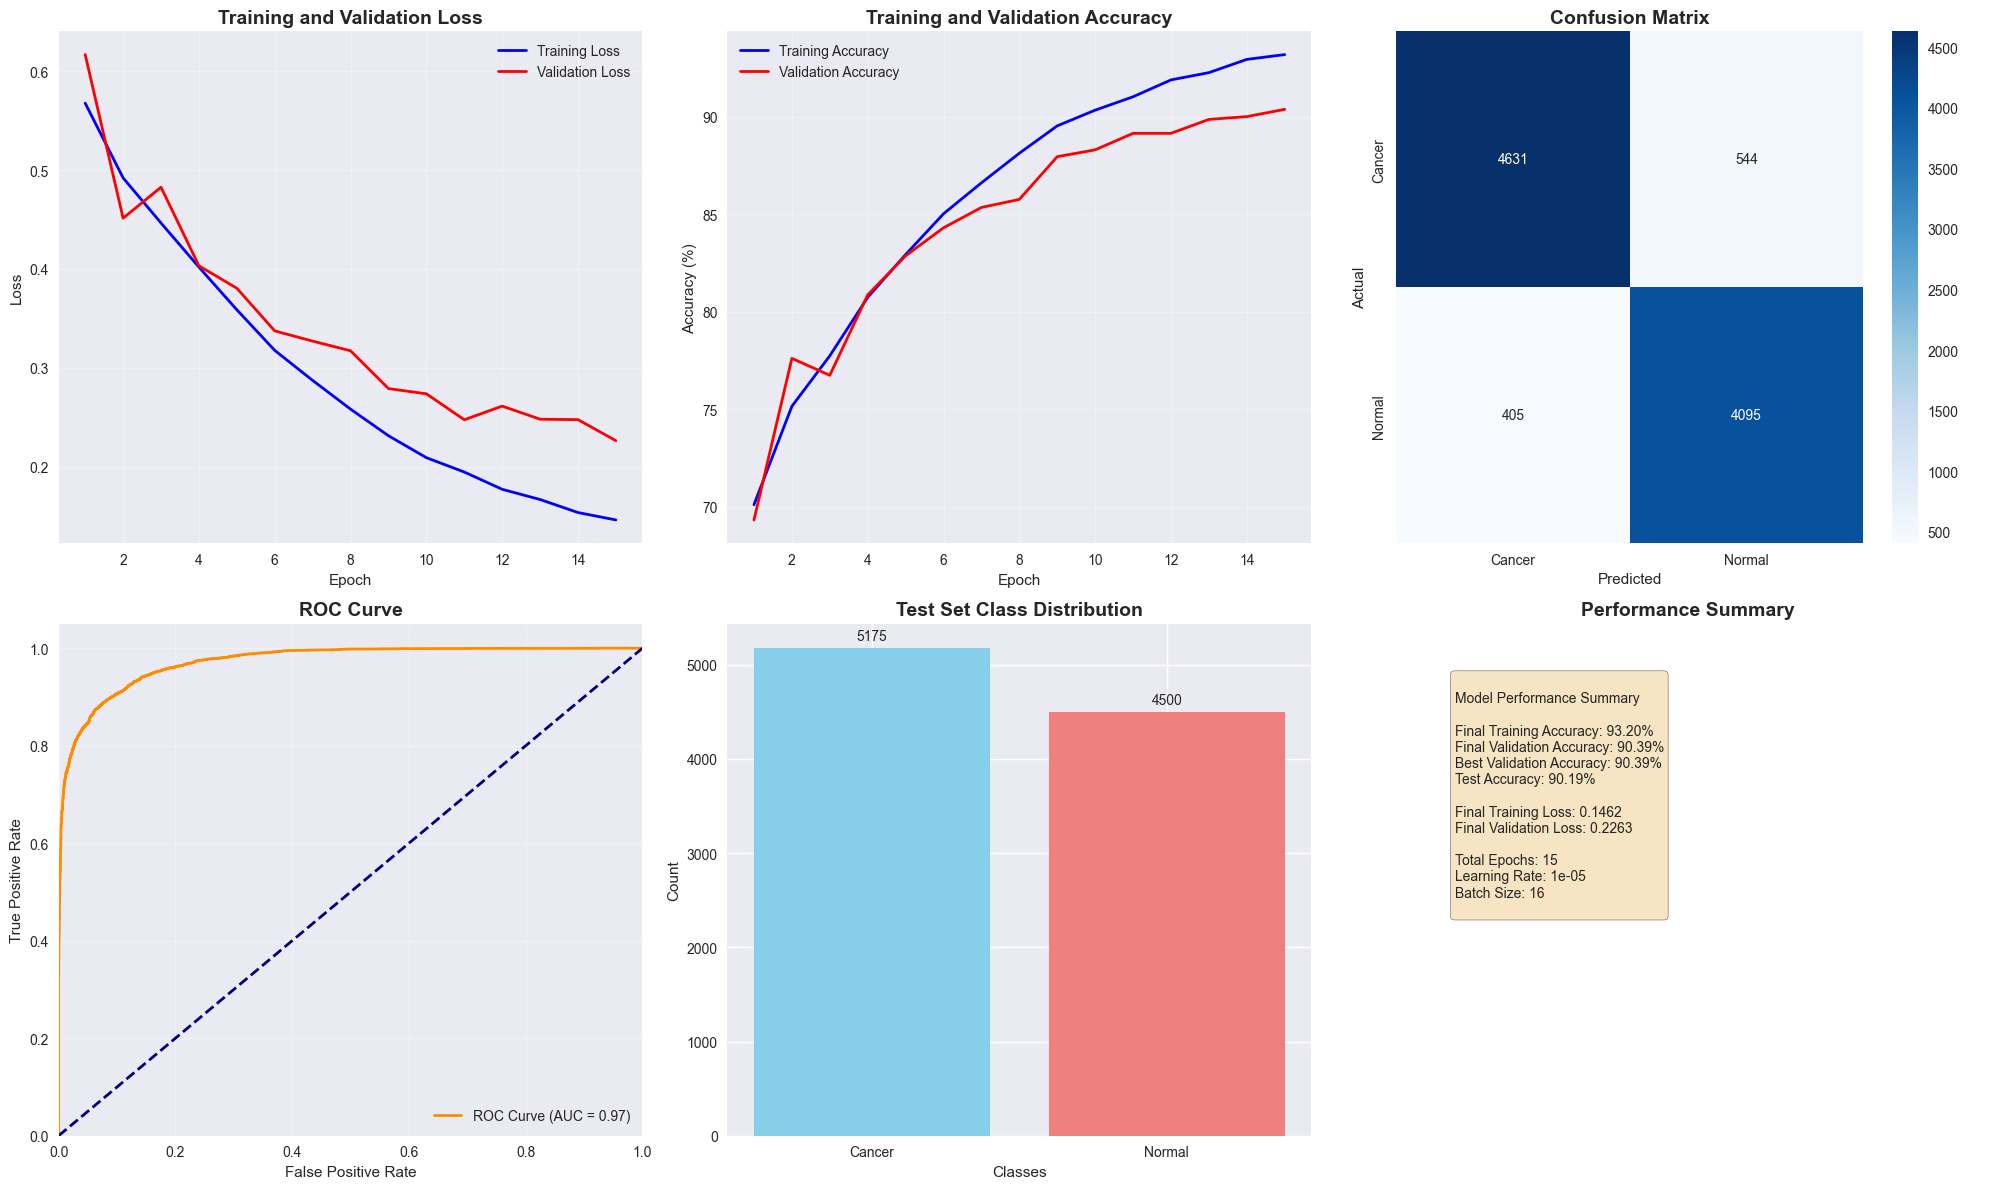


Detailed Classification Report:
              precision    recall  f1-score   support

      Cancer       0.92      0.89      0.91      5175
      Normal       0.88      0.91      0.90      4500

    accuracy                           0.90      9675
   macro avg       0.90      0.90      0.90      9675
weighted avg       0.90      0.90      0.90      9675


Fine-tuning completed successfully!
Results saved to: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_fine_tuned_20250701_100324
Best validation accuracy: 90.39%
Final test accuracy: 90.19%

Saved files:
├── best_model.pth (Best PyTorch model)
├── final_model.pth (Final PyTorch model)
├── model_state_dict.pth (Model weights only)
├── training_results.json (Complete training metrics)
├── fine_tuning_results.png (Visualization plots)
├── best_model_hf/ (Best model in Hugging Face format)
└── final_model_hf/ (Final model in Hugging Face format)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from datetime import datetime
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Import for Hugging Face models
from transformers import AutoModelForImageClassification, AutoConfig

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
base_model_dir = '/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_unfreeze_last_3_20250701_091544'
data_path = '/Volumes/KODAK/folder 02/Brest_cancer_prediction/data/preprocessed_data/breast_cancer_split_dataset'
save_dir = '/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model'

# Create timestamp for new model name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fine_tuned_model_name = f'breast_cancer_vit_fine_tuned_{timestamp}'
fine_tuned_model_path = os.path.join(save_dir, fine_tuned_model_name)

# Create directory for fine-tuned model
os.makedirs(fine_tuned_model_path, exist_ok=True)

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading datasets...")
train_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'train'),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'validation'),
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(data_path, 'test'),
    transform=val_test_transform
)

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Load the pre-trained model from Hugging Face format
print("Loading pre-trained model from Hugging Face format...")
model = None
model_loaded = False

try:
    # First, check if config.json exists
    config_path = os.path.join(base_model_dir, 'config.json')
    if os.path.exists(config_path):
        print(f"Found config.json at: {config_path}")
        
        # Load the model using Hugging Face AutoModel
        model = AutoModelForImageClassification.from_pretrained(
            base_model_dir,
            local_files_only=True,
            trust_remote_code=True
        )
        model = model.to(device)
        model_loaded = True
        print("Model loaded successfully from Hugging Face format!")
        
        # Print model info
        print(f"Model type: {type(model).__name__}")
        print(f"Number of classes: {model.config.num_labels}")
        
    else:
        print("config.json not found!")
        
except Exception as e:
    print(f"Error loading model from Hugging Face format: {e}")
    print("Trying alternative approach...")
    
    # Alternative: Try to load with safetensors directly
    try:
        from safetensors.torch import load_file
        
        # Load the safetensors file
        safetensors_path = os.path.join(base_model_dir, 'model.safetensors')
        if os.path.exists(safetensors_path):
            print(f"Loading safetensors from: {safetensors_path}")
            
            # Load config to understand the model architecture
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            # Create model based on config
            model_config = AutoConfig.from_pretrained(base_model_dir, local_files_only=True)
            model = AutoModelForImageClassification.from_config(model_config)
            
            # Load weights from safetensors
            state_dict = load_file(safetensors_path)
            model.load_state_dict(state_dict)
            model = model.to(device)
            model_loaded = True
            print("Model loaded successfully from safetensors!")
            
    except Exception as e2:
        print(f"Error loading with safetensors: {e2}")

# If still not loaded, try a manual approach
if not model_loaded:
    print("Trying manual approach with Vision Transformer...")
    try:
        # Load config to get model details
        config_path = os.path.join(base_model_dir, 'config.json')
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
            
            print(f"Model architecture: {config.get('architectures', ['Unknown'])}")
            print(f"Number of labels: {config.get('num_labels', 'Unknown')}")
            
            # Create a Vision Transformer model manually
            from transformers import ViTForImageClassification, ViTConfig
            
            # Create config
            vit_config = ViTConfig(
                num_labels=len(train_dataset.classes),
                image_size=224,
                patch_size=16,
                num_channels=3,
                hidden_size=config.get('hidden_size', 768),
                num_hidden_layers=config.get('num_hidden_layers', 12),
                num_attention_heads=config.get('num_attention_heads', 12),
                intermediate_size=config.get('intermediate_size', 3072),
            )
            
            model = ViTForImageClassification(vit_config)
            
            # Try to load weights if safetensors exists
            safetensors_path = os.path.join(base_model_dir, 'model.safetensors')
            if os.path.exists(safetensors_path):
                from safetensors.torch import load_file
                state_dict = load_file(safetensors_path)
                
                # Handle potential key mismatches
                model_state_dict = model.state_dict()
                filtered_state_dict = {}
                
                for key in model_state_dict.keys():
                    if key in state_dict:
                        if model_state_dict[key].shape == state_dict[key].shape:
                            filtered_state_dict[key] = state_dict[key]
                        else:
                            print(f"Shape mismatch for {key}: {model_state_dict[key].shape} vs {state_dict[key].shape}")
                    else:
                        print(f"Key not found in loaded state_dict: {key}")
                
                model.load_state_dict(filtered_state_dict, strict=False)
                print(f"Loaded {len(filtered_state_dict)} out of {len(model_state_dict)} parameters")
            
            model = model.to(device)
            model_loaded = True
            print("Model created and loaded manually!")
            
    except Exception as e3:
        print(f"Manual approach failed: {e3}")

# Final check
if not model_loaded:
    print("\nError: Could not load the pre-trained model in any format.")
    print(f"Directory contents: {os.listdir(base_model_dir)}")
    print("\nPlease ensure you have the correct Hugging Face model format.")
    print("Required files: config.json, model.safetensors (or pytorch_model.bin)")
    exit()

# Verify model is in training mode and has the right number of outputs
print(f"Model output size: {model.classifier.out_features if hasattr(model, 'classifier') else 'Unknown'}")
print(f"Expected classes: {len(train_dataset.classes)}")

# Adjust the final layer if needed
if hasattr(model, 'classifier'):
    if model.classifier.out_features != len(train_dataset.classes):
        print(f"Adjusting classifier from {model.classifier.out_features} to {len(train_dataset.classes)} classes")
        model.classifier = nn.Linear(model.classifier.in_features, len(train_dataset.classes))
        model = model.to(device)

# Fine-tuning parameters
learning_rate = 1e-5
num_epochs = 15
weight_decay = 1e-4

# Setup optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler - FIXED: Removed 'verbose' parameter
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Custom forward function for Hugging Face models
def model_forward(model, x):
    """Handle different model types"""
    if hasattr(model, 'forward') and 'pixel_values' in model.forward.__code__.co_varnames:
        # Hugging Face model
        outputs = model(pixel_values=x)
        return outputs.logits
    else:
        # Standard PyTorch model
        return model(x)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model_forward(model, data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model_forward(model, data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Fine-tuning loop
print("\nStarting fine-tuning...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler and print learning rate changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"Learning rate reduced from {old_lr:.2e} to {new_lr:.2e}")
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, os.path.join(fine_tuned_model_path, 'best_model.pth'))
        # Also save in Hugging Face format
        if hasattr(model, 'save_pretrained'):
            model.save_pretrained(os.path.join(fine_tuned_model_path, 'best_model_hf'))
        print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")

# Test evaluation
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model_forward(model, data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_labels, all_probs

print("\nEvaluating on test set...")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device, train_dataset.classes)

# Calculate test accuracy
test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels)) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate plots and statistics
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Training/Validation Loss
axes[0, 0].plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training/Validation Accuracy
axes[0, 1].plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(range(1, num_epochs+1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes, ax=axes[0, 2])
axes[0, 2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. ROC Curve (for binary classification)
if len(train_dataset.classes) == 2:
    fpr, tpr, _ = roc_curve(test_labels, [prob[1] for prob in test_probs])
    roc_auc = auc(fpr, tpr)
    axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1, 0].legend(loc="lower right")
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'ROC Curve\n(Multi-class)', ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('ROC Curve (Multi-class)', fontsize=14, fontweight='bold')

# 5. Class Distribution
class_counts = [test_labels.count(i) for i in range(len(train_dataset.classes))]
axes[1, 1].bar(train_dataset.classes, class_counts, color=['skyblue', 'lightcoral'])
axes[1, 1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Classes')
axes[1, 1].set_ylabel('Count')
for i, count in enumerate(class_counts):
    axes[1, 1].text(i, count + max(class_counts)*0.01, str(count), ha='center', va='bottom')

# 6. Model Performance Summary
performance_text = f"""
Model Performance Summary

Final Training Accuracy: {train_accuracies[-1]:.2f}%
Final Validation Accuracy: {val_accuracies[-1]:.2f}%
Best Validation Accuracy: {best_val_acc:.2f}%
Test Accuracy: {test_accuracy:.2f}%

Final Training Loss: {train_losses[-1]:.4f}
Final Validation Loss: {val_losses[-1]:.4f}

Total Epochs: {num_epochs}
Learning Rate: {learning_rate}
Batch Size: {batch_size}
"""

axes[1, 2].text(0.1, 0.9, performance_text, transform=axes[1, 2].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axes[1, 2].set_title('Performance Summary', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(fine_tuned_model_path, 'fine_tuning_results.png'), dpi=300, bbox_inches='tight')
plt.show()

# Generate detailed classification report
class_report = classification_report(test_labels, test_preds, target_names=train_dataset.classes, output_dict=True)
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=train_dataset.classes))

# Save training history and results
results = {
    'model_name': fine_tuned_model_name,
    'training_config': {
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'weight_decay': weight_decay
    },
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    },
    'final_results': {
        'best_val_accuracy': best_val_acc,
        'test_accuracy': test_accuracy,
        'classification_report': class_report
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'classes': train_dataset.classes
    }
}

# Save results to JSON
with open(os.path.join(fine_tuned_model_path, 'training_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

# Save final model in both formats
torch.save(model, os.path.join(fine_tuned_model_path, 'final_model.pth'))
torch.save(model.state_dict(), os.path.join(fine_tuned_model_path, 'model_state_dict.pth'))

# Save in Hugging Face format if possible
if hasattr(model, 'save_pretrained'):
    model.save_pretrained(os.path.join(fine_tuned_model_path, 'final_model_hf'))

print(f"\nFine-tuning completed successfully!")
print(f"Results saved to: {fine_tuned_model_path}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final test accuracy: {test_accuracy:.2f}%")

# Print file structure
print(f"\nSaved files:")
print(f"├── best_model.pth (Best PyTorch model)")
print(f"├── final_model.pth (Final PyTorch model)")
print(f"├── model_state_dict.pth (Model weights only)")
print(f"├── training_results.json (Complete training metrics)")
print(f"├── fine_tuning_results.png (Visualization plots)")
print(f"├── best_model_hf/ (Best model in Hugging Face format)")
print(f"└── final_model_hf/ (Final model in Hugging Face format)")

## model evaluation thorugh prediction 

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from transformers import ViTForImageClassification, ViTImageProcessor
import warnings
warnings.filterwarnings('ignore')

class BreastCancerPredictor:
    def __init__(self, model_path, model_name='google/vit-base-patch16-224', num_classes=2, swap_labels=False):
        """
        Initialize the breast cancer predictor
        
        Args:
            model_path (str): Path to the fine-tuned model
            model_name (str): Base ViT model name
            num_classes (int): Number of classes (2 for binary classification)
            swap_labels (bool): Whether to swap the class labels (fix inverted predictions)
        """
        self.model_path = model_path
        self.model_name = model_name
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.swap_labels = swap_labels
        
        # Original class labels (may need to be swapped based on training)
        if swap_labels:
            # Swapped labels to fix inverted predictions
            self.class_labels = {0: 'Cancer Detected', 1: 'No Cancer'}
            print("⚠️  Using swapped labels to correct inverted predictions")
        else:
            # Standard labels
            self.class_labels = {0: 'No Cancer', 1: 'Cancer Detected'}
            print("ℹ️  Using standard labels")
        
        # Load model and processor
        self.model = None
        self.processor = None
        self.load_model()
        
    def load_model(self):
        """Load the fine-tuned model with PyTorch 2.6 compatibility"""
        try:
            print(f"Loading model from: {self.model_path}")
            print(f"Using device: {self.device}")
            
            # Load the image processor
            self.processor = ViTImageProcessor.from_pretrained(self.model_name)
            
            # Load the model architecture
            self.model = ViTForImageClassification.from_pretrained(
                self.model_name,
                num_labels=self.num_classes,
                ignore_mismatched_sizes=True
            )
            
            # Load the fine-tuned weights with multiple fallback strategies
            if os.path.exists(self.model_path):
                checkpoint = None
                
                # Strategy 1: Try weights_only=True first (most secure)
                try:
                    print("Attempting to load with weights_only=True...")
                    checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=True)
                    print("✓ Successfully loaded with weights_only=True")
                except Exception as e:
                    print(f"Failed with weights_only=True: {str(e)[:100]}...")
                    
                    # Strategy 2: Try with safe globals
                    try:
                        print("Attempting to load with safe globals...")
                        
                        # Define safe globals at the module level to avoid scoping issues
                        safe_globals = [
                            ViTForImageClassification,
                            torch.nn.Linear,
                            torch.nn.LayerNorm,
                            torch.nn.Dropout,
                            torch.nn.GELU,
                            torch.nn.Module,
                            torch.Tensor,
                            torch.nn.Parameter
                        ]
                        
                        # Check if safe_globals context manager exists (PyTorch 2.0+)
                        if hasattr(torch.serialization, 'safe_globals'):
                            with torch.serialization.safe_globals(safe_globals):
                                checkpoint = torch.load(self.model_path, map_location=self.device)
                            print("✓ Successfully loaded with safe globals")
                        else:
                            # Fallback for older PyTorch versions
                            print("safe_globals not available, trying direct load...")
                            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
                            print("✓ Successfully loaded with direct load")
                            
                    except Exception as e2:
                        print(f"Failed with safe globals: {str(e2)[:100]}...")
                        
                        # Strategy 3: Use weights_only=False (if you trust the source)
                        try:
                            print("Attempting to load with weights_only=False...")
                            checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
                            print("✓ Successfully loaded with weights_only=False")
                        except Exception as e3:
                            print(f"All loading strategies failed: {str(e3)}")
                            raise Exception("Could not load model with any strategy")
                
                # Handle different checkpoint formats
                if checkpoint is not None:
                    state_dict = None
                    
                    # Check if checkpoint contains label mapping information
                    if isinstance(checkpoint, dict) and 'class_labels' in checkpoint:
                        stored_labels = checkpoint['class_labels']
                        print(f"Found stored class labels: {stored_labels}")
                        
                        # Check if we need to swap labels based on stored mapping
                        if stored_labels != self.class_labels and not self.swap_labels:
                            print("⚠️  Detected label mismatch! Consider using swap_labels=True")
                    
                    if isinstance(checkpoint, dict):
                        # Check for different dictionary keys
                        if 'model_state_dict' in checkpoint:
                            state_dict = checkpoint['model_state_dict']
                            print("Found 'model_state_dict' in checkpoint")
                        elif 'state_dict' in checkpoint:
                            state_dict = checkpoint['state_dict']
                            print("Found 'state_dict' in checkpoint")
                        elif 'model' in checkpoint:
                            state_dict = checkpoint['model']
                            print("Found 'model' in checkpoint")
                        else:
                            # Assume the entire dict is the state dict
                            state_dict = checkpoint
                            print("Using entire checkpoint as state dict")
                    elif hasattr(checkpoint, 'state_dict'):
                        # If it's a model object, get its state dict
                        state_dict = checkpoint.state_dict()
                        print("Extracted state_dict from model object")
                    else:
                        # Assume it's already a state dict
                        state_dict = checkpoint
                        print("Using checkpoint directly as state dict")
                    
                    # Load the state dict with error handling
                    try:
                        missing_keys, unexpected_keys = self.model.load_state_dict(state_dict, strict=False)
                        
                        # Print information about missing/unexpected keys
                        if missing_keys:
                            print(f"Missing keys: {missing_keys}")
                        if unexpected_keys:
                            print(f"Unexpected keys: {unexpected_keys}")
                        
                        print("✓ Model weights loaded successfully!")
                    except Exception as load_error:
                        print(f"Error loading state dict: {str(load_error)}")
                        # Try to fix common key mismatches
                        if 'classifier' in str(load_error) or 'head' in str(load_error):
                            print("Attempting to fix classifier layer mismatch...")
                            # Remove classifier/head layers from state_dict
                            filtered_state_dict = {k: v for k, v in state_dict.items() 
                                                 if not any(layer in k for layer in ['classifier', 'head'])}
                            missing_keys, unexpected_keys = self.model.load_state_dict(filtered_state_dict, strict=False)
                            print("✓ Model weights loaded with classifier fix!")
                        else:
                            raise load_error
                
            else:
                raise FileNotFoundError(f"Model file not found at: {self.model_path}")
            
            # Move model to device and set to evaluation mode
            self.model.to(self.device)
            self.model.eval()
            print("✓ Model ready for inference!")
            
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            raise
    
    def preprocess_image(self, image_path):
        """
        Preprocess the input image
        
        Args:
            image_path (str): Path to the input image
            
        Returns:
            torch.Tensor: Preprocessed image tensor
        """
        try:
            # Load image
            if isinstance(image_path, str):
                image = Image.open(image_path).convert('RGB')
            else:
                image = image_path.convert('RGB')
            
            # Use the processor to preprocess the image
            inputs = self.processor(images=image, return_tensors="pt")
            
            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            return inputs
            
        except Exception as e:
            print(f"Error preprocessing image: {str(e)}")
            raise
    
    def predict(self, image_path, return_probabilities=True):
        """
        Make prediction on a single image
        
        Args:
            image_path (str or PIL.Image): Path to image or PIL Image object
            return_probabilities (bool): Whether to return class probabilities
            
        Returns:
            dict: Prediction results
        """
        try:
            # Preprocess image
            inputs = self.preprocess_image(image_path)
            
            # Make prediction
            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits
                
                # Get probabilities
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # Get predicted class
                predicted_class = torch.argmax(probabilities, dim=-1).item()
                
                # Get confidence score
                confidence = probabilities[0][predicted_class].item()
                
                # Prepare results
                results = {
                    'predicted_class': predicted_class,
                    'predicted_label': self.class_labels[predicted_class],
                    'confidence': confidence,
                    'confidence_percentage': confidence * 100,
                    'raw_logits': logits.cpu().numpy().tolist(),
                    'raw_probabilities': probabilities.cpu().numpy().tolist()
                }
                
                if return_probabilities:
                    results['probabilities'] = {
                        self.class_labels[i]: prob.item() 
                        for i, prob in enumerate(probabilities[0])
                    }
                
                return results
                
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            raise
    
    def predict_batch(self, image_paths, batch_size=8):
        """
        Make predictions on multiple images
        
        Args:
            image_paths (list): List of image paths
            batch_size (int): Batch size for processing
            
        Returns:
            list: List of prediction results
        """
        results = []
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_results = []
            
            for path in batch_paths:
                try:
                    result = self.predict(path)
                    result['image_path'] = path
                    batch_results.append(result)
                except Exception as e:
                    print(f"Error processing {path}: {str(e)}")
                    batch_results.append({
                        'image_path': path,
                        'error': str(e)
                    })
            
            results.extend(batch_results)
            
        return results
    
    def print_prediction_summary(self, result):
        """Print a formatted summary of the prediction"""
        print("\n" + "="*50)
        print("BREAST CANCER PREDICTION RESULTS")
        print("="*50)
        
        if 'error' in result:
            print(f"❌ Error: {result['error']}")
            return
        
        print(f"🏥 Prediction: {result['predicted_label']}")
        print(f"🎯 Confidence: {result['confidence_percentage']:.2f}%")
        
        if 'probabilities' in result:
            print("\n📊 Detailed Probabilities:")
            for label, prob in result['probabilities'].items():
                print(f"   {label}: {prob*100:.2f}%")
        
        # Add raw output for debugging
        if 'raw_logits' in result:
            print(f"\n🔍 Raw logits: {result['raw_logits']}")
            print(f"🔍 Raw probabilities: {result['raw_probabilities']}")
        
        # Add interpretation
        if 'Cancer Detected' in result['predicted_label']:
            print("\n⚠️  The model indicates CANCER may be present.")
        else:
            print("\n✅ The model indicates NO CANCER detected.")
            
        print("\n⚠️  IMPORTANT DISCLAIMER:")
        print("This is an AI prediction tool for research purposes only.")
        print("Always consult with medical professionals for diagnosis.")
        print("="*50)
    
    def test_predictions_with_known_samples(self, cancer_image_path=None, no_cancer_image_path=None):
        """
        Test the model with known samples to verify correct labeling
        
        Args:
            cancer_image_path (str): Path to a known cancer image
            no_cancer_image_path (str): Path to a known no-cancer image
        """
        print("\n" + "="*60)
        print("TESTING MODEL PREDICTIONS WITH KNOWN SAMPLES")
        print("="*60)
        
        if cancer_image_path and os.path.exists(cancer_image_path):
            print(f"\n🔍 Testing with KNOWN CANCER image: {cancer_image_path}")
            result = self.predict(cancer_image_path)
            self.print_prediction_summary(result)
            
            if 'Cancer Detected' not in result['predicted_label']:
                print("\n❌ WARNING: Model predicted NO CANCER for a known cancer image!")
                print("   This suggests the labels might be swapped.")
                print("   Try creating a new instance with swap_labels=True")
        
        if no_cancer_image_path and os.path.exists(no_cancer_image_path):
            print(f"\n🔍 Testing with KNOWN NO-CANCER image: {no_cancer_image_path}")
            result = self.predict(no_cancer_image_path)
            self.print_prediction_summary(result)
            
            if 'No Cancer' not in result['predicted_label']:
                print("\n❌ WARNING: Model predicted CANCER for a known no-cancer image!")
                print("   This suggests the labels might be swapped.")
                print("   Try creating a new instance with swap_labels=True")

def test_model_loading(model_path, swap_labels=False):
    """
    Test just the model loading without predictions
    """
    try:
        print("Testing model loading...")
        predictor = BreastCancerPredictor(model_path, swap_labels=swap_labels)
        print("✅ Model loading test passed!")
        return predictor
    except Exception as e:
        print(f"❌ Model loading test failed: {str(e)}")
        return None

def test_model_prediction(model_path, test_image_path, swap_labels=False):
    """
    Test the model with a sample image
    """
    try:
        # First test loading
        predictor = test_model_loading(model_path, swap_labels=swap_labels)
        if predictor is None:
            return
        
        # Test prediction
        if test_image_path and os.path.exists(test_image_path):
            print(f"\nTesting prediction with image: {test_image_path}")
            result = predictor.predict(test_image_path)
            predictor.print_prediction_summary(result)
        else:
            print("✅ Model is ready for predictions!")
            print("To test with an image, provide a valid test_image_path")
            
    except Exception as e:
        print(f"❌ Prediction test failed: {str(e)}")

# Main execution
if __name__ == "__main__":
    # Your model path
    MODEL_PATH = "/Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_fine_tuned_20250701_100324/best_model.pth"
    
    print("="*60)
    print("BREAST CANCER PREDICTION SYSTEM - PYTORCH 2.6 COMPATIBLE")
    print("="*60)
    
    # Ask user about label swapping
    print("\n🤔 If you're experiencing inverted predictions (cancer images predicted as no-cancer),")
    print("   you might need to swap the labels.")
    
    swap_choice = input("\nDo you want to swap labels? (y/n): ").strip().lower()
    swap_labels = swap_choice == 'y'
    
    # Test model loading first
    predictor = test_model_loading(MODEL_PATH, swap_labels=swap_labels)
    
    if predictor is not None:
        print("\n" + "="*50)
        print("INTERACTIVE PREDICTION MODE")
        print("="*50)
        print("Model loaded successfully! You can now make predictions.")
        print("Commands:")
        print("  - Enter image path to analyze")
        print("  - 'test' to test with known samples")
        print("  - 'swap' to toggle label swapping")
        print("  - 'quit' to exit")
        
        while True:
            try:
                user_input = input("\nEnter command or image path: ").strip()
                
                if user_input.lower() == 'quit':
                    print("Goodbye!")
                    break
                elif user_input.lower() == 'test':
                    cancer_path = input("Enter path to known cancer image (or press Enter to skip): ").strip()
                    no_cancer_path = input("Enter path to known no-cancer image (or press Enter to skip): ").strip()
                    
                    cancer_path = cancer_path if cancer_path else None
                    no_cancer_path = no_cancer_path if no_cancer_path else None
                    
                    predictor.test_predictions_with_known_samples(cancer_path, no_cancer_path)
                elif user_input.lower() == 'swap':
                    print("Reloading model with swapped labels...")
                    predictor = test_model_loading(MODEL_PATH, swap_labels=not predictor.swap_labels)
                    if predictor:
                        print("✅ Model reloaded with different label configuration!")
                    else:
                        print("❌ Failed to reload model")
                elif os.path.exists(user_input):
                    try:
                        result = predictor.predict(user_input)
                        predictor.print_prediction_summary(result)
                    except Exception as e:
                        print(f"❌ Error processing image: {str(e)}")
                else:
                    print("❌ Invalid command or image file not found.")
                    print("Available commands: 'test', 'swap', 'quit', or enter an image path")
                    
            except KeyboardInterrupt:
                print("\n\nExiting...")
                break
            except Exception as e:
                print(f"❌ Error: {str(e)}")
    else:
        print("❌ Cannot start interactive mode - model loading failed.")
        print("\nTroubleshooting tips:")
        print("1. Check if the model path exists")
        print("2. Ensure you have the required dependencies installed")
        print("3. Verify the model file is not corrupted")
        print("4. Check PyTorch version compatibility")
        print("5. Try running: pip install torch torchvision transformers pillow")
        print("6. If predictions are inverted, try swap_labels=True")

BREAST CANCER PREDICTION SYSTEM - PYTORCH 2.6 COMPATIBLE

🤔 If you're experiencing inverted predictions (cancer images predicted as no-cancer),
   you might need to swap the labels.
Testing model loading...
⚠️  Using swapped labels to correct inverted predictions
Loading model from: /Volumes/KODAK/folder 02/Brest_cancer_prediction/model/fine_tuning_model/breast_cancer_vit_fine_tuned_20250701_100324/best_model.pth
Using device: cpu


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Attempting to load with weights_only=True...
Failed with weights_only=True: Weights only load failed. This file can still be loaded, to do so you have two options, do those...
Attempting to load with safe globals...
Failed with safe globals: Weights only load failed. This file can still be loaded, to do so you have two options, do those...
Attempting to load with weights_only=False...
✓ Successfully loaded with weights_only=False
Extracted state_dict from model object
✓ Model weights loaded successfully!
✓ Model ready for inference!
✅ Model loading test passed!

INTERACTIVE PREDICTION MODE
Model loaded successfully! You can now make predictions.
Commands:
  - Enter image path to analyze
  - 'test' to test with known samples
  - 'swap' to toggle label swapping
  - 'quit' to exit

BREAST CANCER PREDICTION RESULTS
🏥 Prediction: No Cancer
🎯 Confidence: 99.89%

📊 Detailed Probabilities:
   Cancer Detected: 0.11%
   No Cancer: 99.89%

🔍 Raw logits: [[-3.012147903442383, 3.819734573364258]]
🔍